In [ ]:
!pip install PyYAML --upgrade
!pip install labelme
!pip install shapely
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 636 kB 9.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.5 MB 7.5 MB/s 
     |████████████████████████████████| 7.7 MB 16.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 68.3 MB 40 kB/s 
     |████████████████████████████████| 317 kB 52.0 MB/s 
  Created wheel for labelme: filename=labelme-4.5.9-py3-none-any.whl size=1465486 sha256=4c88be5f9353ebf30344cd97772a0fd9a10af0a9b4f4369f5d1f313ae45b5415
  Stored in directory: /root/.cache/pip/wheels/1a/69/e0/8e8530643e291ff5b3eeb05568d873ad42b08c15166885a288
  Created wheel for imgviz: filename=imgviz-1.2.6-py3-none-any.whl size=7674115 sha256=006ac01fcca5efd219a9827e6be247be2db1d83e87072bfc0b3a018ed430cac4
  Stored in directory: /r

In [ ]:
!wget https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz

--2021-08-14 08:24:29--  https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.199.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580345649 (553M) [application/gzip]
Saving to: ‘ShelfImages.tar.gz’

ShelfImages.tar.gz  100%[===================>] 553.46M   295MB/s    in 1.9s    

2021-08-14 08:24:31 (295 MB/s) - ‘ShelfImages.tar.gz’ saved [580345649/580345649]



In [ ]:
!tar -xzf /content/ShelfImages.tar.gz
!rm /content/ShelfImages.tar.gz

In [ ]:
!wget https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv

--2021-08-14 08:24:36--  https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517978 (506K) [text/plain]
Saving to: ‘annotations.csv’

annotations.csv     100%[===================>] 505.84K  --.-KB/s    in 0.02s   

2021-08-14 08:24:36 (20.8 MB/s) - ‘annotations.csv’ saved [517978/517978]



In [ ]:
import os
test = os.listdir("/content/ShelfImages/test")
train = os.listdir("/content/ShelfImages/train")

In [ ]:
import pandas as pd
df = pd.read_csv('/content/annotations.csv',names=["filename","xmin","ymin","xmax","ymax","class"]) 

In [ ]:
df['class'] = 1
df['class'].value_counts()

1    13184
Name: class, dtype: int64

In [ ]:
train_anno=df[df['filename'].isin(train)]
test_anno=df[df['filename'].isin(test)]

In [ ]:
"""from PIL import Image                                              
import os, sys                       

path = "/content/ShelfImages/train/"
dirs = os.listdir(path)                                       

def resize():
  global path
  for item in dirs:
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
      imResize = im.resize((1920,1080), Image.ANTIALIAS)
      imResize.save(f+'.JPG', 'jpg', quality=80)
resize()"""

'from PIL import Image                                              \nimport os, sys                       \n\npath = "/content/ShelfImages/train/"\ndirs = os.listdir(path)                                       \n\ndef resize():\n  global path\n  for item in dirs:\n    if os.path.isfile(path+item):\n      im = Image.open(path+item)\n      f, e = os.path.splitext(path+item)\n      imResize = im.resize((1920,1080), Image.ANTIALIAS)\n      imResize.save(f+\'.JPG\', \'jpg\', quality=80)\nresize()'

In [ ]:
import numpy as np
import json
import pandas as pd
import cv2

di = {"instances_train.json":train_anno,"instances_test.json":test_anno}

for i in ["instances_train.json","instances_test.json"]:
  save_json_path = i #output path to the json
  data = di[i]
  images = []
  categories = []
  annotations = []

  category = {}
  category["supercategory"] = 'none'
  category["id"] = 0
  category["name"] = 'None'
  categories.append(category)

  data['fileid'] = data['filename'].astype('category').cat.codes
  data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
  data['categoryid'] = data['categoryid']+1
  data['annid'] = data.index

  def image(row):
    image = {}
    im = cv2.imread("ShelfImages/"+i[i.index("_")+1:i.index(".")]+"/"+row.filename)
    image["height"] = im.shape[0]
    image["width"] = im.shape[1]
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

  def category(row):
    category = {}
    category["supercategory"] = 'Product'
    print(row)
    category["id"] = row.categoryid
    category["name"] = 'Product'
    return category

  def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

  for row in data.itertuples():
    annotations.append(annotation(row))

  imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
  for row in imagedf.itertuples():
    images.append(image(row))

  catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
  for row in catdf.itertuples():
    categories.append(category(row))

  data_coco = {}
  data_coco["images"] = images
  data_coco["categories"] = categories
  data_coco["annotations"] = annotations
  json.dump(data_coco, open(save_json_path, "w"), indent=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Pandas(Index=0, filename='C1_P01_N1_S2_1.JPG', xmin=1008, ymin=1552, xmax=1260, ymax=1928, _6=1, fileid=0, categoryid=1, annid=0)
Pandas(Index=238, filename='C1_P02_N1_S5_1.JPG', xmin=1032, ymin=2080, xmax=1204, ymax=2408, _6=1, fileid=0, categoryid=1, annid=238)


In [ ]:
!git clone https://github.com/aim-uofa/AdelaiDet.git
%cd AdelaiDet
!python setup.py build develop

Cloning into 'AdelaiDet'...
remote: Enumerating objects: 2072, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 2072 (delta 50), reused 87 (delta 43), pack-reused 1957
Receiving objects: 100% (2072/2072), 562.56 KiB | 13.08 MiB/s, done.
Resolving deltas: 100% (1261/1261), done.
/content/AdelaiDet
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/adet
copying adet/__init__.py -> build/lib.linux-x86_64-3.7/adet
creating build/lib.linux-x86_64-3.7/adet/evaluation
copying adet/evaluation/text_eval_script.py -> build/lib.linux-x86_64-3.7/adet/evaluation
copying adet/evaluation/__init__.py -> build/lib.linux-x86_64-3.7/adet/evaluation
copying adet/evaluation/rrc_evaluation_funcs.py -> build/lib.linux-x86_64-3.7/adet/evaluation
copying adet/evaluation/text_evaluation.py -> build/lib.linux-x86_64-3.7/adet/evaluation
creating build/lib.linux-x86_64-3.7/adet/str

In [ ]:
import random
import cv2
import os 
import numpy as np
import pandas as pd  
import copy
import torch
import base64   
import json
import math
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import files

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from adet.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import ColorMode
from detectron2.engine.defaults import DefaultPredictor
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

In [ ]:
## Registering data in COCO format
for d in ["train","test"]:
    register_coco_instances(f"grocery_{d}", {}, f"/content/instances_{d}.json", f"/content/ShelfImages/{d}/")

In [ ]:
## Loading the data

dataset_dicts = DatasetCatalog.get("grocery_train")
grocery_metadata = MetadataCatalog.get("grocery_train")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [ ]:
## Making a Cutsom Mapper to perform augmentations

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((800,800)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomApply(T.RandomRotation(angle=[-30,30], expand=True, center=None, sample_style="range", interp=None), prob=0.25),
                      T.RandomApply(T.RandomCrop(crop_type="relative_range", crop_size=(0.4, 0.4)), 
                      prob=0.20)
                      ]
   
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

## Class which can call the custom mapper we made

class GroceryTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

{'file_name': '/content/ShelfImages/train/C2_P07_N1_S2_1.JPG', 'height': 1598, 'width': 2272, 'image_id': 145, 'annotations': [{'iscrowd': 0, 'bbox': [0, 920, 256, 444], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [188, 896, 256, 444], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1988, 256, 256, 444], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [232, 248, 236, 424], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [448, 252, 236, 424], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [452, 904, 256, 444], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [696, 920, 256, 444], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [8, 240, 236, 424], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1200, 260, 256, 444], 'category_id': 1, 'bbox_mode':

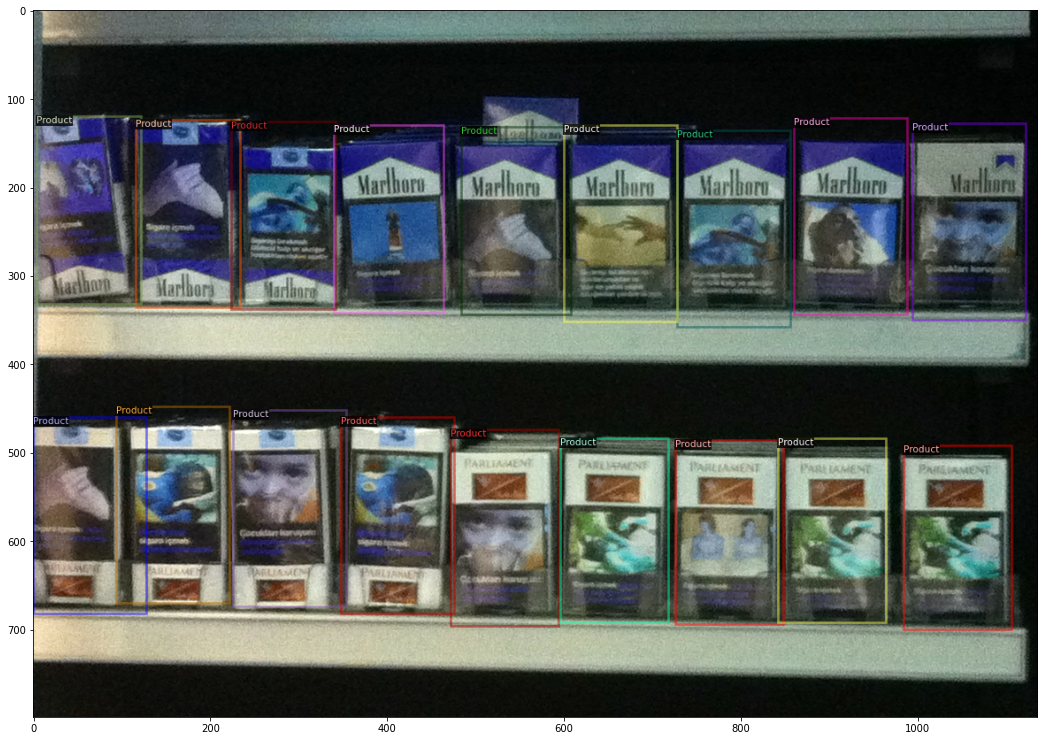

{'file_name': '/content/ShelfImages/train/C2_P04_N1_S5_1.JPG', 'height': 1808, 'width': 1918, 'image_id': 119, 'annotations': [{'iscrowd': 0, 'bbox': [1060, 904, 120, 196], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1072, 1248, 120, 176], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1072, 204, 116, 200], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1100, 1552, 136, 176], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1104, 572, 112, 208], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [112, 1512, 112, 208], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1180, 908, 120, 196], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1188, 204, 116, 200], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1216, 1560, 136, 176], 'category_id': 1

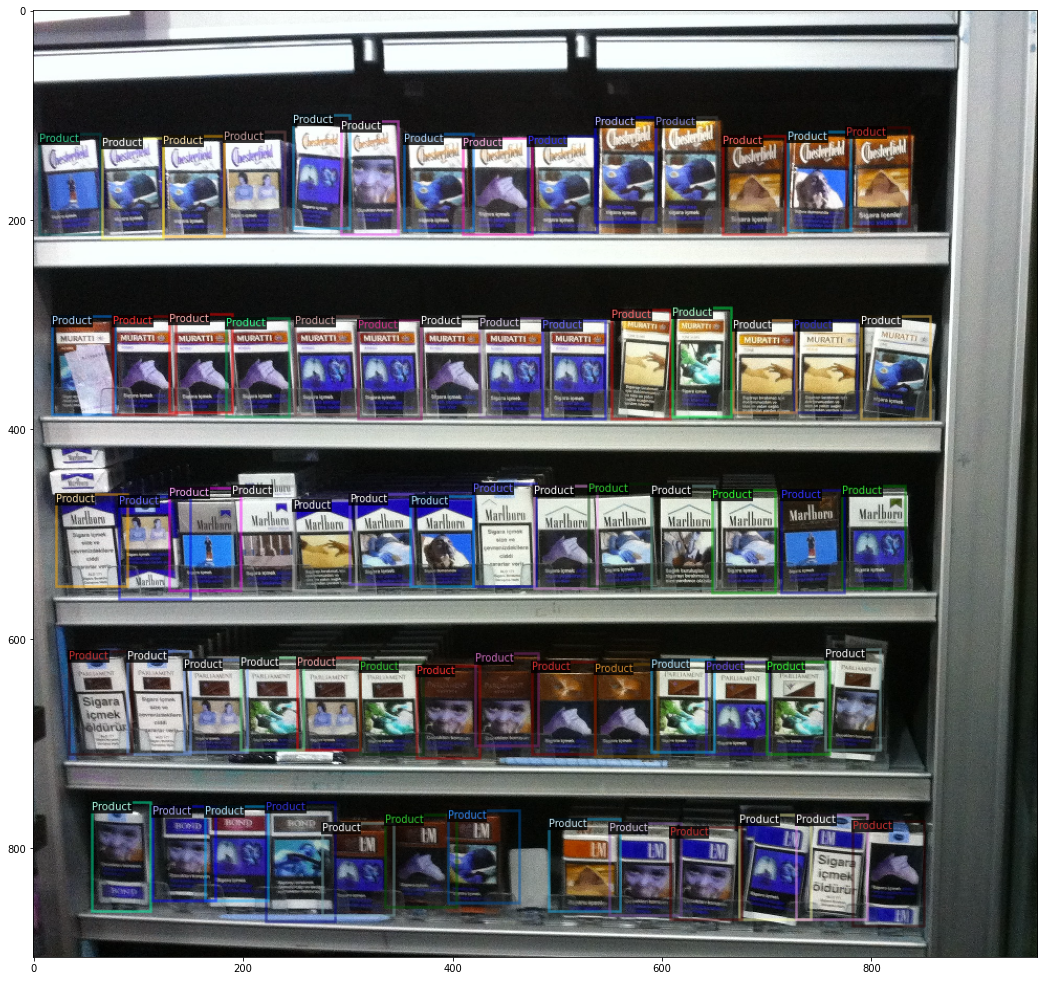

{'file_name': '/content/ShelfImages/train/C2_P08_N1_S6_2.JPG', 'height': 1695, 'width': 1066, 'image_id': 157, 'annotations': [{'iscrowd': 0, 'bbox': [128, 124, 128, 168], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [148, 992, 108, 164], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [152, 716, 108, 164], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [156, 1516, 104, 168], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [164, 1264, 112, 168], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [240, 128, 128, 168], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [252, 712, 108, 164], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [256, 1264, 112, 168], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [264, 996, 108, 164], 'category_id': 1, 'bbox_m

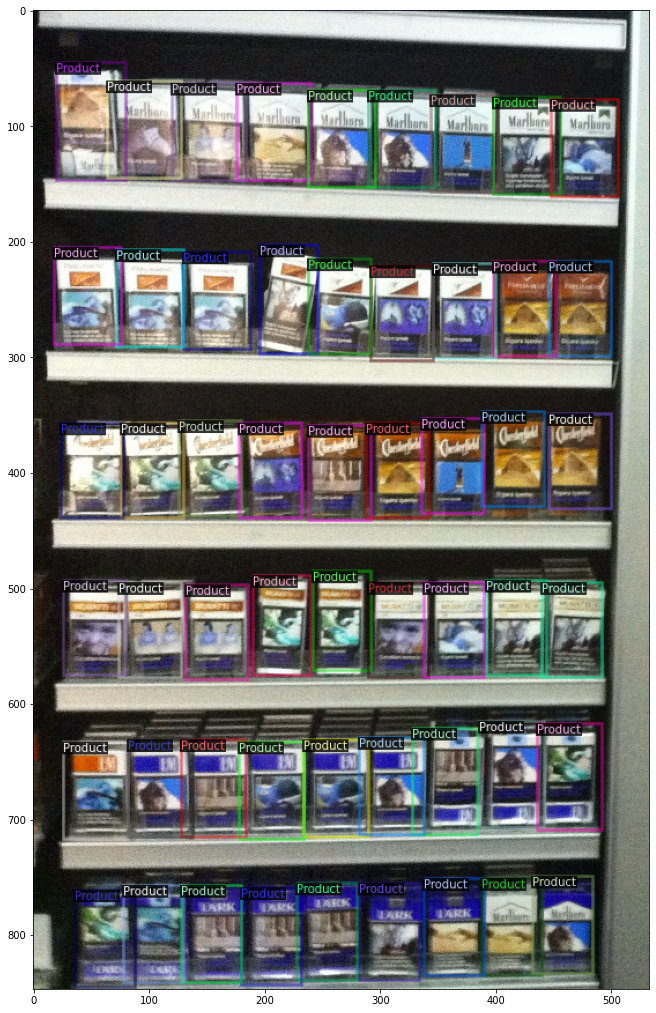

In [ ]:
#Display random 3 images:
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=diamond_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (18, 18))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
%cd AdelaiDet

[Errno 2] No such file or directory: 'AdelaiDet'
/content/AdelaiDet


In [ ]:
#Training
cfg = get_cfg()
cfg.merge_from_file("configs/FCOS-Detection/MS_R_50_2x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

Config 'configs/FCOS-Detection/MS_R_50_2x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [ ]:
cfg.DATASETS.TRAIN = ("grocery_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 20000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = GroceryTrainer(cfg) 
trainer.resume_or_load(resume=True)

[08/14 11:09:21 d2.engine.defaults]: Model:
OneStageDetector(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      

In [ ]:
trainer.train()

[08/14 11:09:26 d2.engine.train_loop]: Starting training from iteration 10000


/usr/local/lib/python3.7/dist-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  tensor = torch.from_numpy(np.ascontiguousarray(img))
/usr/local/lib/python3.7/dist-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be

[08/14 11:09:38 d2.utils.events]:  eta: 1:38:25  iter: 10019  total_loss: 0.8301  loss_fcos_cls: 0.0931  loss_fcos_loc: 0.1239  loss_fcos_ctr: 0.6099  time: 0.5754  data_time: 0.2003  lr: 0.00025  max_mem: 3231M
[08/14 11:09:50 d2.utils.events]:  eta: 1:37:18  iter: 10039  total_loss: 0.8445  loss_fcos_cls: 0.1051  loss_fcos_loc: 0.1395  loss_fcos_ctr: 0.6038  time: 0.5831  data_time: 0.1397  lr: 0.00025  max_mem: 3362M
[08/14 11:10:02 d2.utils.events]:  eta: 1:36:03  iter: 10059  total_loss: 0.8536  loss_fcos_cls: 0.1022  loss_fcos_loc: 0.1438  loss_fcos_ctr: 0.6123  time: 0.5813  data_time: 0.1101  lr: 0.00025  max_mem: 3362M
[08/14 11:10:13 d2.utils.events]:  eta: 1:35:51  iter: 10079  total_loss: 0.8601  loss_fcos_cls: 0.1134  loss_fcos_loc: 0.1442  loss_fcos_ctr: 0.613  time: 0.5806  data_time: 0.1206  lr: 0.00025  max_mem: 3362M
[08/14 11:10:24 d2.utils.events]:  eta: 1:34:00  iter: 10099  total_loss: 0.8653  loss_fcos_cls: 0.1066  loss_fcos_loc: 0.1483  loss_fcos_ctr: 0.6069  ti

In [ ]:
#Testing
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.FCOS.INFERENCE_TH_TEST = 0.3
cfg.MODEL.MEInst.INFERENCE_TH_TEST = 0.3
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.3
predictor = DefaultPredictor(cfg)

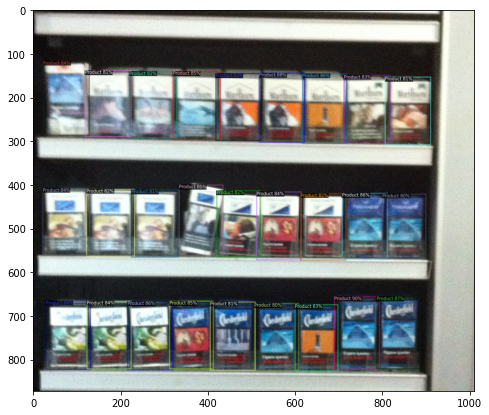

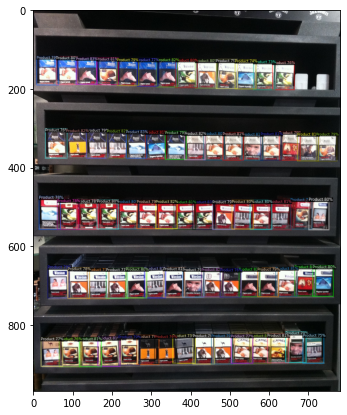

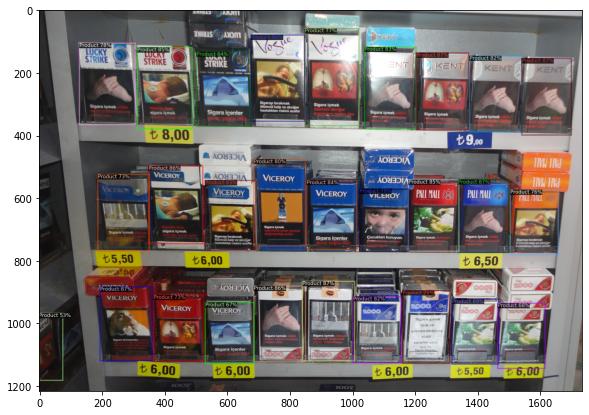

In [ ]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   metadata=grocery_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. Only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

In [ ]:
# Evaluation
!mkdir output/inference

mkdir: cannot create directory ‘output/inference’: File exists


In [ ]:
from detectron2.evaluation import (
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)
from detectron2.evaluation import inference_on_dataset

In [ ]:
output_folder="output/"        
output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
evaluator_list = []
evaluator_type = MetadataCatalog.get("grocery_test").evaluator_type
evaluator_list.append(COCOEvaluator("grocery_test", cfg, True, output_folder))

In [ ]:
eval = DatasetEvaluators(evaluator_list)

In [ ]:
from detectron2.data import build_detection_test_loader
val_loader = build_detection_test_loader(cfg, "grocery_test")
print(inference_on_dataset(trainer.model, val_loader, eval))

WARNING [08/14 13:19:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/14 13:19:09 d2.data.datasets.coco]: Loaded 71 images in COCO format from /content/instances_test.json
[08/14 13:19:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/14 13:19:09 d2.data.common]: Serializing 71 elements to byte tensors and concatenating them all ...
[08/14 13:19:09 d2.data.common]: Serialized dataset takes 0.10 MiB
[08/14 13:19:09 d2.evaluation.evaluator]: Start inference on 71 batches
[08/14 13:19:13 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.1724 s/iter. Inference: 0.1081 s/iter. Eval: 0.0005 s/iter. Total: 0.2810 s/iter. ETA=0:00:16
[08/14 13:19:18 d2.evaluation.evaluator]: Inference done 31/71. Dataloading: 0.1549 s/iter. Inference: 0.1053 s/iter. Eval: 0.0004 s/iter. Total: 0.2613 s/iter. 